In [98]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from python.analysis import Plots
from python.analysis.shower_merging import SetPlotStyle
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, erf
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp

from rich import print

SetPlotStyle()

def figure_dimensions(x, orientation : str = "horizontal"):
    nearest_square = int(np.ceil(x**0.5))

    if x < 4:
        dim = (1, x)
    elif (nearest_square - 1) * nearest_square >= x:
        dim = ((nearest_square - 1), nearest_square)
    else:
        dim = (nearest_square, nearest_square)
    
    if orientation == "vertical":
        dim = dim[::-1]
    return dim

def Hist2DComparison(x, y, x_range, y_range, x_labels = None, y_labels = None, titles = None, bins = 50, cmap = "plasma", func = None, orientation = "horizontal"):
    if x_labels is None: x_labels = [""]*len(x)
    if y_labels is None: y_labels = [""]*len(y)
    if titles is None: titles = [""] * len(x)

    dim = figure_dimensions(len(x), orientation)
    fig_size = (6.4 * dim[1], 4.8 * dim[0])
    ranges = [x_range, y_range]

    vmax = 0
    for xs, ys in zip(x, y):
        h, _, _ = np.histogram2d(xs, ys, bins, range = ranges)
        vmax = max(vmax, np.max(h))

    fig = plt.figure(figsize = fig_size)
    for i in range(len(x)):
        plt.subplot(*dim, i + 1)
        if func is None:
            _, _, _, im = plt.hist2d(x[i], y[i], bins, range = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        else:
            _, _, _, im = func(x = x[i], y = y[i], bins = bins, ranges = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        plt.xlabel(x_labels[i])
        plt.ylabel(y_labels[i])
        plt.title(titles[i])
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.subplots_adjust(right=0.84)
    fig.colorbar(im, cax = cbar_ax)

def LinearFit(x, m):
    return m * x

def LinearCorrection(x, m):
    return x / m


def ResponseCorrection(x, a, b, c):
    return a * np.log(x - b) + c


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
df = pd.read_hdf("work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5")
df["residual"] = df.reco_energy - df.true_energy
df["fractional_error"] = (df.reco_energy / df.true_energy) - 1
print(df)

reco_energy  true_energy  true_mother     residual  fractional_error
0       133.802572   268.863259          111  -135.060687         -0.502340
1       127.616533  1343.636619          211 -1216.020086         -0.905022
2       104.872036   129.958027          111   -25.085991         -0.193031
3        75.675744    89.715949          111   -14.040205         -0.156496
4       563.250869   770.033836          111  -206.782967         -0.268538
...            ...          ...          ...          ...               ...
16581   545.426464   531.016507          111    14.409957          0.027137
16582   516.226603   335.723310          111   180.503293          0.537655
16583   565.426627   385.056909          111   180.369718          0.468424
16584    35.134860    90.807447          111   -55.672587         -0.613084
16585   246.498951   420.794547          111  -174.295596         -0.414206

[16586 rows x 5 columns]

[-211  -13    0   13  111  130  211  310  321 2112 2212 3112 3122 3212
 3222]

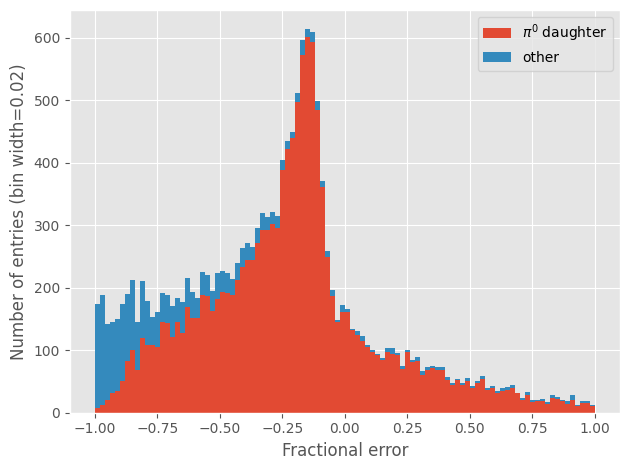

In [100]:
print(np.unique(df.true_mother))

pi0_mother = df.true_mother == 111
Plots.PlotHist([df[pi0_mother].fractional_error, df[~pi0_mother].fractional_error], stacked = True, range = [-1, 1], xlabel = "Fractional error", label = ["$\pi^{0}$ daughter", "other"])
df = df[pi0_mother]

energy_range = (0, 1500)

In [101]:
def binned_dataframe(bins : list) -> list:
    binned_data = []
    for i in range(1, len(bins)):
        data = df[(df.reco_energy < bins[i]) & (df.reco_energy > bins[i-1])]
        binned_data.append(data[data.true_energy < max(energy_range)])
    return binned_data

# Linear Correction

In [102]:
def linear_fit(bins : list) -> float:
    x = (bins[1:] + bins[:-1]) / 2
    y = np.array([d.true_energy.mean() for d in binned_dataframe(bins)])

    popt, pcov = curve_fit(LinearFit, x, y)

    print(popt, pcov**0.5)
    perr = np.array([pcov[i][i] for i in range(len(popt))])**0.5

    Plots.Plot(x, y, marker = "x", linestyle = "")
    Plots.Plot(x, LinearFit(x, *popt), newFigure = False, label = "fit")
    plt.fill_between(x, LinearFit(x, *(popt + perr)), LinearFit(x, *(popt - perr)), color = "C3", alpha = 0.5)
    Plots.Plot(x, x, newFigure = False, label = "$y = x$", xlabel = "Reco shower energy (MeV)", ylabel = "True shower energy (MeV)")
    plt.legend()


    Plots.PlotHist2D(df.true_energy, df.reco_energy, x_range = [0, 1500], y_range = [0, 1500], cmap = "winter")
    Plots.Plot(x, LinearFit(x, *popt), newFigure = False, label = "fit", color = "C0")
    Plots.Plot(x, x, newFigure = False, color = "black", label = "$y = x$")
    Plots.Plot(x, y, marker = "x", linestyle = "", ylabel = "True shower energy (MeV)", xlabel = "Reco shower energy (MeV)", newFigure = False, color = "C0")
    return popt[0]


def LinearFitPerformance(linear_correction : float):
    corrected_energy = LinearCorrection(df.reco_energy, linear_correction)

    fe = (df.reco_energy / df.true_energy) - 1
    fec = (corrected_energy / df.true_energy) - 1

    print(f"correction factor : {linear_correction}")
    print(f"mean shower energy fractional error: {np.mean(fe)} +- {np.std(fe)}")
    print(f"mean shower energy fractional error after correction: {np.mean(np.mean(fec))} +- {np.std(fec)}")

    Plots.PlotHistComparison([df.reco_energy, corrected_energy], labels = ["uncorrected", "corrected"], xRange = [0, 2000], xlabel = "Shower energy (MeV)")
    Plots.PlotHistComparison([df.reco_energy - df.true_energy, corrected_energy - df.true_energy], labels = ["uncorrected", "corrected"], xRange=[-500, 500], xlabel = "Shower energy residual (MeV)")

    Hist2DComparison([df.true_energy, df.true_energy], [fe, fec], [0, 2000], [-1, 1], bins = 50, cmap = "Accent", x_labels = ["True shower energy (MeV)"]*2, y_labels = ["Fractional error"]*2, titles = ["uncorrected", "corrected"])
    return

[0.82971351] [[0.0348277]]

correction factor : 0.829713513762402

mean shower energy fractional error: -0.16237320982323436 +- 0.47217237207914

mean shower energy fractional error after correction: 0.009537359923764869 +- 0.5690788015950671

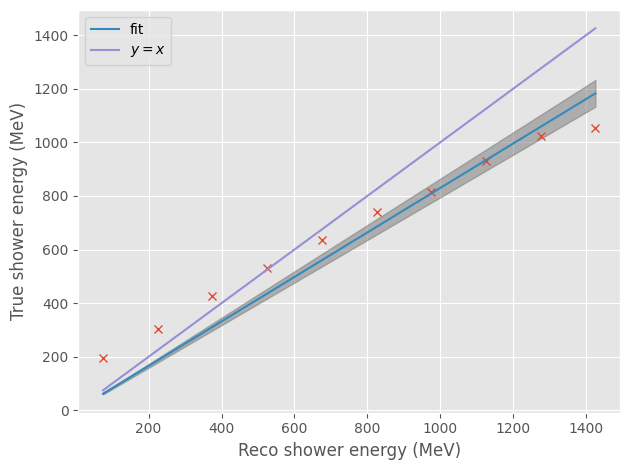

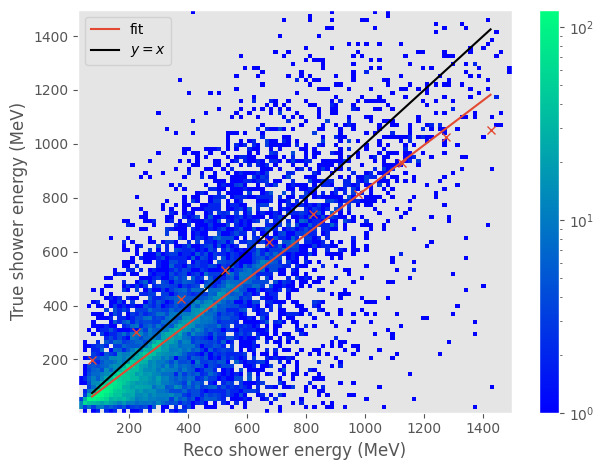

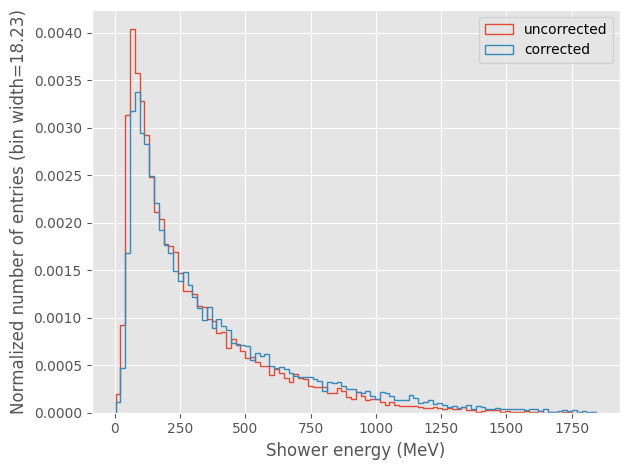

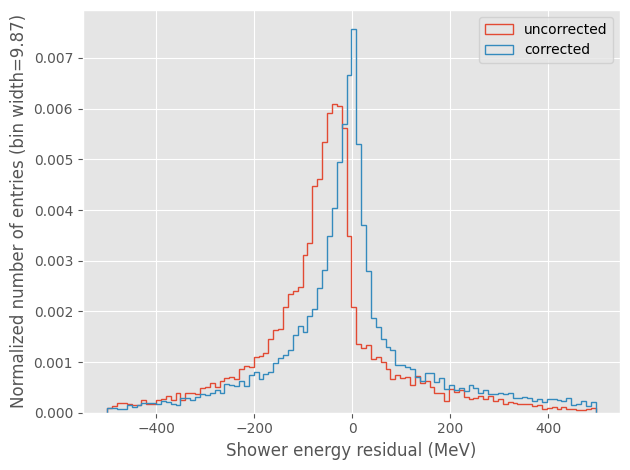

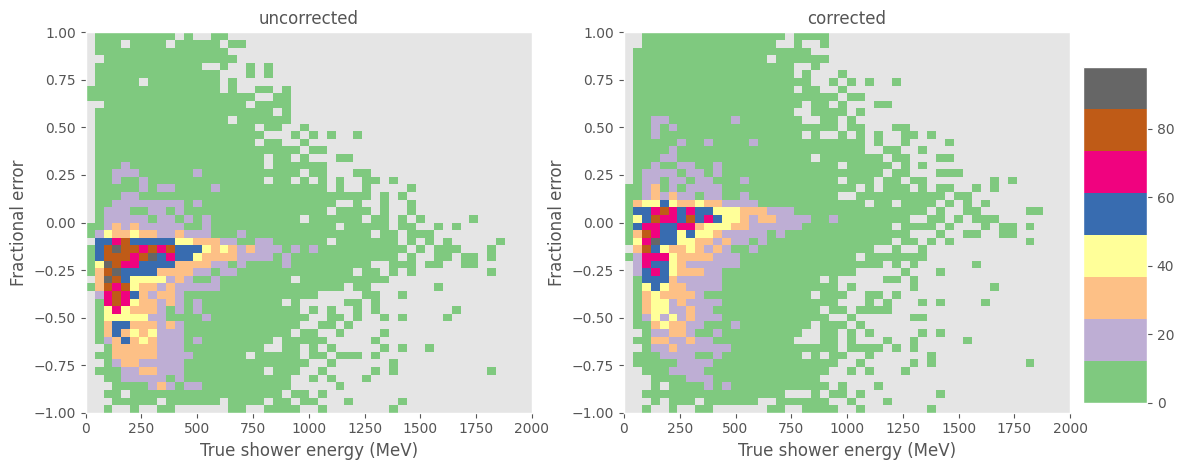

In [103]:
bins = np.linspace(min(energy_range), max(energy_range), 11)
linear_correction = linear_fit(bins)
LinearFitPerformance(linear_correction)

# Parameterised correction

In [7]:
class student_t:
    n_params = 4
    
    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, A, mu, nu, l):
        t = (x - mu)/ l
        return (A**2 / l) * (gamma((nu + 1)/2) / (np.sqrt(nu * np.pi) * gamma(nu/2))) * (1 + t**2/nu)**(-(nu + 1)/2)

    @staticmethod
    def bounds():
        return [(0, -np.inf, 0.01, -np.inf),
                (np.inf, np.inf, 10, np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.median(x), 2, np.std(x)]

    @staticmethod
    def mu(A, mu, nu, l):
        return mu

    @staticmethod
    def var(A, mu, nu, l):
        if nu > 2:
            return nu / (nu - 2)
        elif (nu <= 2) and nu > 1:
            return np.Inf
        else:
            return np.NaN

class double_gaussian:
    n_params = 6

    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        return A_1 * np.exp(-(x - mu_1)**2 / (2 * sigma_1**2)) + A_2 * np.exp(-(x - mu_2)**2 / (2 * sigma_2**2))

    @staticmethod
    def bounds():
        return [(0, -np.inf, 0.001, 0, -np.inf, 0.001),
                (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.mean(x), np.std(x), max(y), np.mean(x), np.std(x)]

    @staticmethod
    def mu(A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        w_1 = A_1 / (A_1 + A_2)
        w_2 = A_2 / (A_1 + A_2)
        return w_1 * mu_1 + w_2 * mu_2

    @staticmethod
    def var(A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        w_1 = A_1 / (A_1 + A_2)
        w_2 = A_2 / (A_1 + A_2)

        return w_1 * (sigma_1**2) + w_2 * (sigma_2**2) + (w_1 * (mu_1**2) + w_2 * (mu_2**2) - (w_1*mu_1 + w_2*mu_2)**2)

class crystal_ball:
    n_params = 5

    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, S, mu, sigma, alpha, n):
        t = (x - mu) / sigma

        a_alpha = abs(alpha)
        n_alpha = n / a_alpha

        A = (n_alpha)**n * np.exp(-a_alpha**2 / 2)

        B = n_alpha - a_alpha

        C = (n_alpha) * (1/(n - 1)) * np.exp(-a_alpha**2/2)

        D = np.sqrt(np.pi / 2) *(1 + erf(a_alpha/np.sqrt(2)))

        N = 1 / (C + D) # should be 1 / sigma * (C + D), but I dont want to normalise the function

        y = np.where(t > -alpha, np.exp(-t**2 / 2), A * (B - t)**-n)
        return S * N * y

    @staticmethod
    def bounds():
        return [(0, -np.inf, -np.inf, 1, 2),
                (np.inf, np.inf, np.inf, 3, 10)]

    @staticmethod
    def p0(x,y):
        return [max(y), np.mean(x), np.std(x), 1, 2]

    @staticmethod
    def mu(S, mu, sigma, alpha, n):
        return mu

In [8]:
def fit_regions(variable : str, v_range : list, funcs, reco_bins : list, hist_bins : int, log : bool = False):
    def print_log(x):
        if log: print(x)
    
    dim = figure_dimensions(len(reco_bins) - 1)
    plt.subplots(*dim, figsize = (6.4 * dim[1], 4.8 * dim[0]))

    cv = []
    cv_err = []
    fig_handles = None
    fig_labels = None
    for i in range(1, len(bins)):
        print_log(i)
        binned_data = df[(df.reco_energy > bins[i-1]) & (df.reco_energy < bins[i])]
        plt.subplot(*dim, i)

        y, edges = np.histogram(binned_data[variable], bins = hist_bins, range = [min(v_range), max(v_range)])
        x = (edges[1:] + edges[:-1]) / 2
        x_interp = np.linspace(min(x), max(x), hist_bins*5)

        best_f = None
        best_popt = None
        best_perr = None
        k_best = None
        p_best = None

        for f in funcs:
            function = f()
            popt = None
            pcov = None
            perr = None
            try:
                popt, pcov = curve_fit(function.func, x, y, p0 = function.p0(x, y), method = "dogbox", bounds = function.bounds())
                perr = np.sqrt(np.diag(pcov))
                print_log(popt)
                print_log(perr)
                print_log(pcov)
            except:
                print_log("could not fit")
                pass
            y_pred = function.func(x, *popt) if popt is not None else None
            if y_pred is not None:
                k, p = ks_2samp(y, y_pred)
            else:
                k = 1
                p = 0

            if p_best is None or p > p_best : # larger p value suggests a better fit
                p_best = p
                k_best = k
                best_popt = popt
                best_perr = perr
                best_f = f

        mean = None
        mean_error = None
        if best_popt is not None:
            function = best_f()
            mean = function.mu(*best_popt)
            mean_error = mean - (function.mu(*(best_popt + best_perr)) + function.mu(*(best_popt + best_perr))) / 2
            y_pred = function.func(x, *best_popt)
            y_pred_interp = function.func(x_interp, *best_popt)
            k, p = ks_2samp(y, y_pred)

            # Plots.Plot(x, y_pred, marker = "x", color = "black", linestyle = "", newFigure = False, label = "")
            Plots.Plot(x_interp, y_pred_interp, marker = "", color = "black", newFigure = False, label = "fit")
            plt.axvline(mean, color = "black", linestyle = "--", label = "central value")
        Plots.PlotHist(binned_data[variable], bins = hist_bins, newFigure = False, title = f"bin : {[reco_bins[i-1], reco_bins[i]]}", range = [min(v_range), max(v_range)])

        plt.axvline(np.mean(binned_data[variable]), linestyle = "--", color = "C1", label = "mean")
        # plt.axvline(np.median(binned_data[variable]), linestyle = "--", color = "C2", label = "median")
        # plt.axvline(x[np.argmax(y)], linestyle = "--", color = "C3", label = "mode")

        if not fig_handles: fig_handles, fig_labels = plt.gca().get_legend_handles_labels()

        if best_popt is not None:
            text = ""
            for j in range(len(best_popt)):
                text += f"\np{j}: ${best_popt[j]:.2f}\pm${best_perr[j]:.2f}"
            text += f"\nks : {k_best:.2f}, p : {p_best:.2f}"
            legend = plt.gca().legend(handlelength = 0, labels = [text[1:]], title = best_f.__name__.replace("_", " "))
            for l in legend.legendHandles:
                l.set_visible(False)

        cv.append(mean if mean is not None else np.mean(binned_data[variable]))
        cv_err.append(mean_error if mean_error is not None else np.std(binned_data[variable]))
    
    for j in range(i, dim[0] * dim[1]):
        plt.subplot(*dim, j + 1)
        plt.gca().set_axis_off()

    plt.gcf().legend(fig_handles, fig_labels, loc = "lower right")
    plt.gcf().supxlabel(variable.replace("_", " "))
    plt.tight_layout()
    return np.array(cv), abs(np.array(cv_err))


def calculate_mean(variable : str, v_range: list, reco_bins : list):
    means = []
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        means.append(ranged_data[variable].mean())
    return means


def calculate_median(variable : str, v_range: list, reco_bins : list):
    med = []
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        med.append(ranged_data[variable].median())
    return med


def calculate_std(variable : str, v_range: list, reco_bins : list):
    std = []
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        std.append(ranged_data[variable].std())
    return std


def calculate_sem(variable : str, v_range: list, reco_bins : list):
    sem = []
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        sem.append(ranged_data[variable].std() / np.sqrt(len(ranged_data[variable])))
    return sem


def count_entries(variable: str, v_range: list, bins : list):
    counts = []
    for i in range(1, len(bins)):
        binned_data = df[(df.reco_energy > bins[i-1]) & (df.reco_energy < bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        counts.append(len(ranged_data))
    return counts


def create_bins(value : pd.Series, n_entries, v_range : list = None):
    sorted_value = value.sort_values()
    n_bins = len(sorted_value) // n_entries

    bins = []
    for i in range(n_bins + 1):
        mi = sorted_value.values[i * n_entries]
        bins.append(mi)
    if v_range:
        bins[0] = min(v_range)
        bins[-1] = max(v_range)
    return np.array(bins)


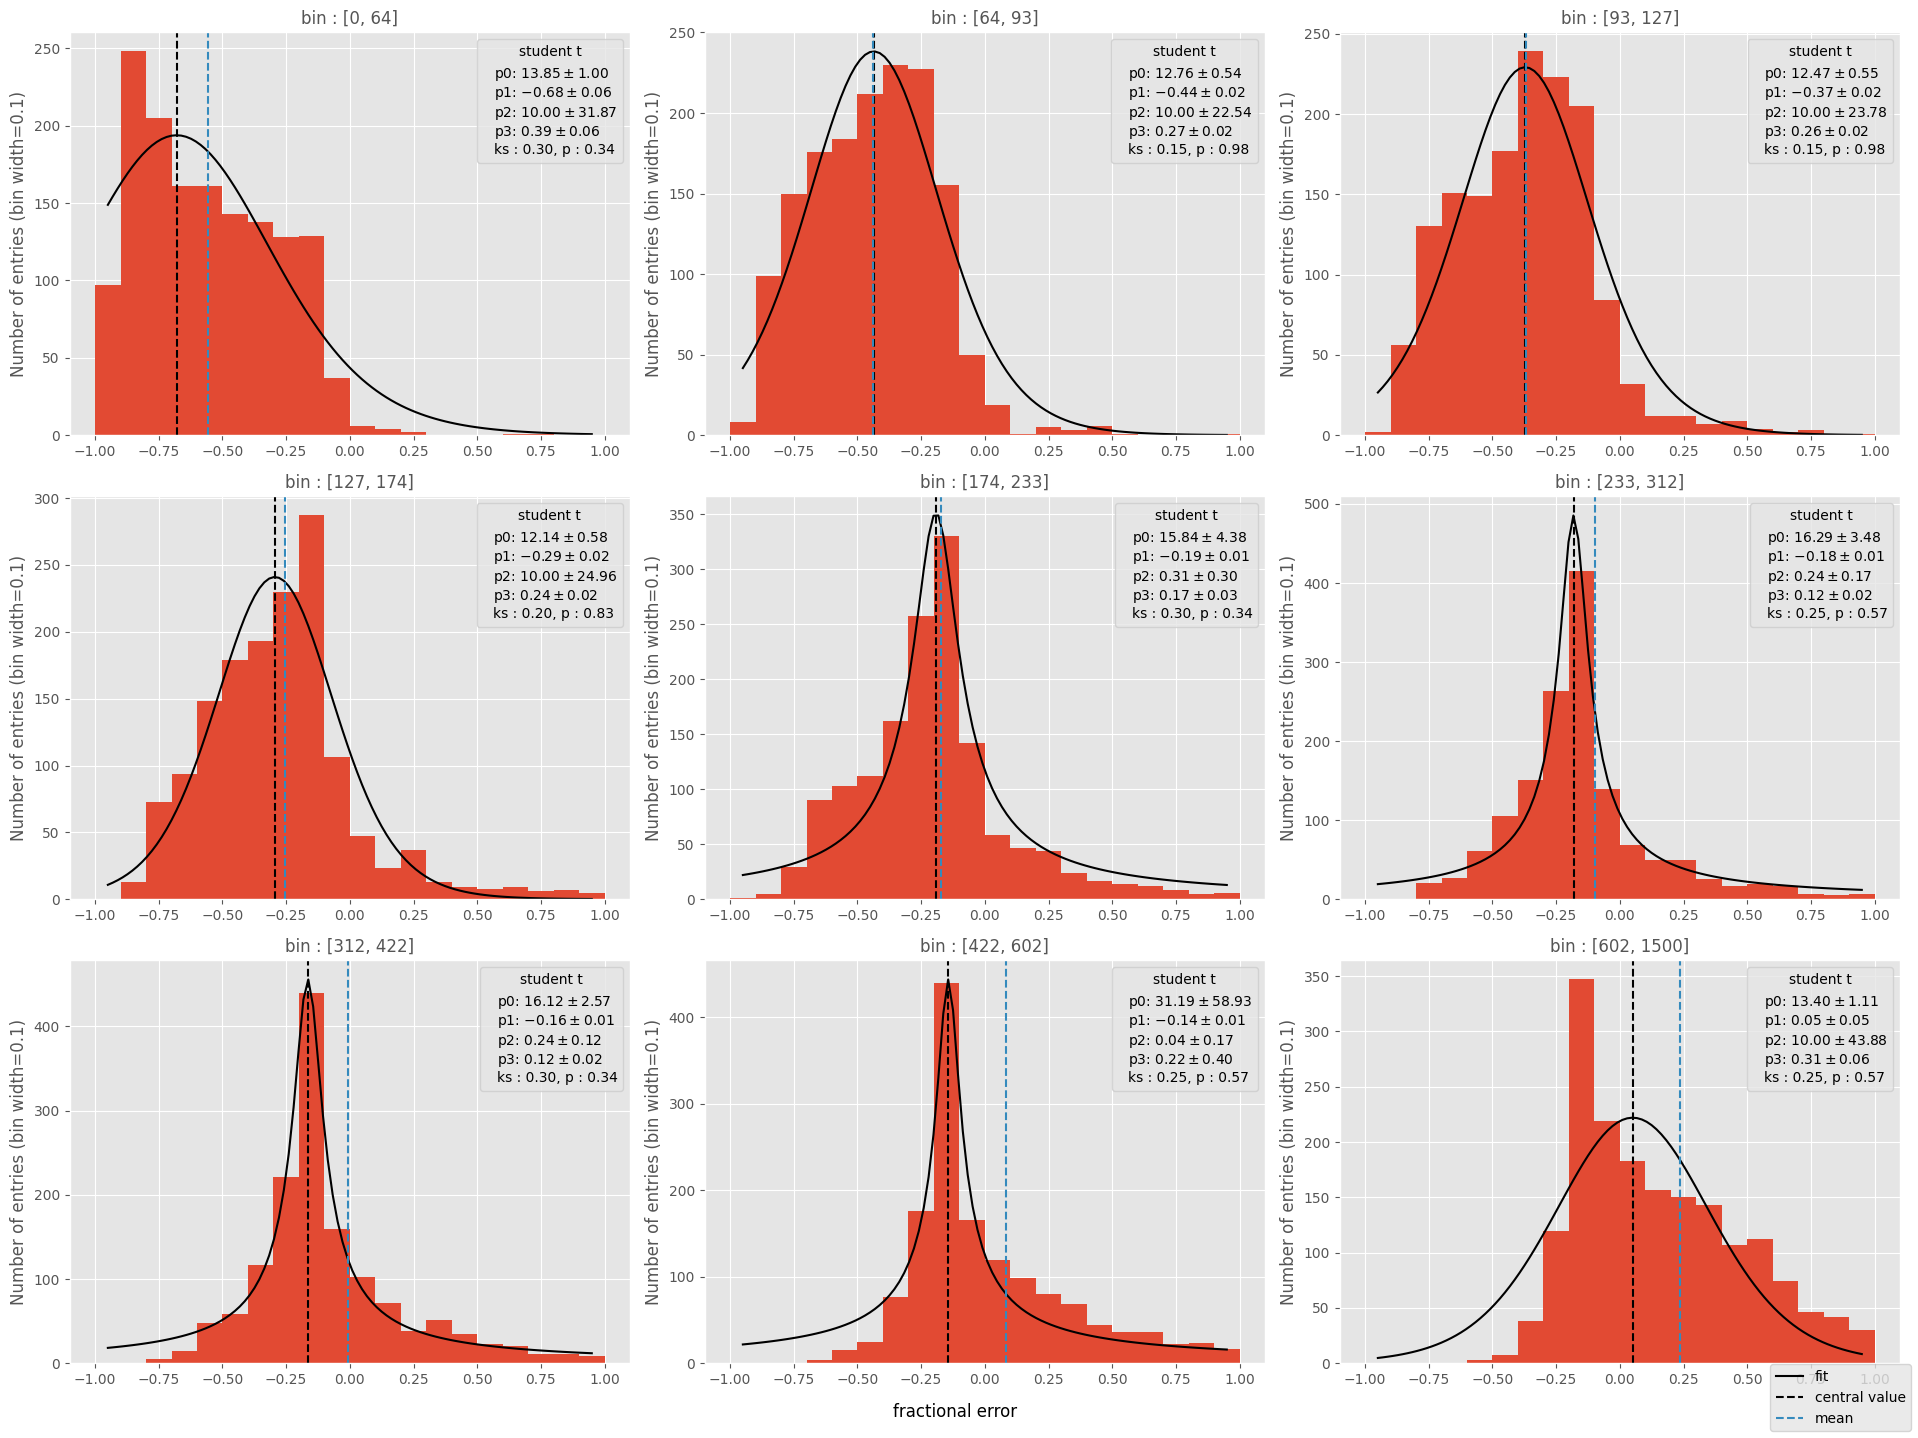

In [9]:
bins = np.array(create_bins(df.reco_energy, 1500, energy_range), dtype = int)
cv, cv_err = fit_regions("fractional_error", [-1, 1], [student_t], bins, 20)
means_simple = calculate_mean("fractional_error", [-1, 1], bins)
median = calculate_median("fractional_error", [-1, 1], bins)
std = calculate_std("fractional_error", [-1, 1], bins)
sem = calculate_sem("fractional_error", [-1, 1], bins)

<ErrorbarContainer object of 3 artists>

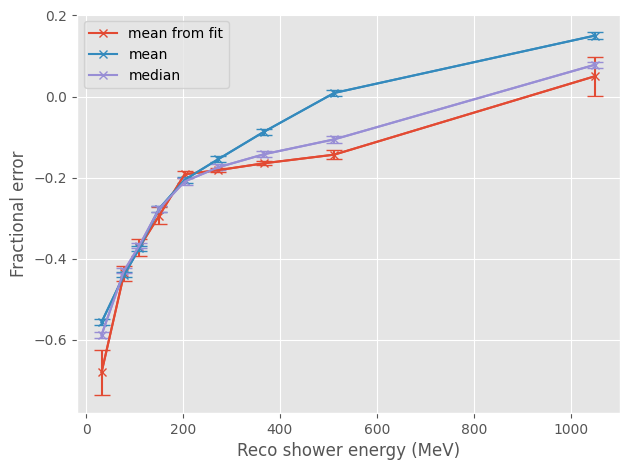

In [10]:
x = (bins[1:] + bins[:-1]) / 2
Plots.Plot(x, cv, marker = "x", label = "mean from fit")
plt.errorbar(x, cv, cv_err, color = "C0", capsize = 6)

Plots.Plot(x, means_simple, marker = "x", newFigure = False, label = "mean")
plt.errorbar(x, means_simple, sem, color = "C1", capsize = 6)

Plots.Plot(x, median, marker = "x", newFigure = False, y_scale = "linear", label = "median", xlabel = "Reco shower energy (MeV)", ylabel = "Fractional error")
plt.errorbar(x, median, sem, color = "C2", capsize = 6)


## fracional error fit

reduced_chi_squared : 0.009253668025112011

reduced_chi_squared : 0.018703865870945913

/tmp/ipykernel_15518/4175437139.py:66: RuntimeWarning: invalid value encountered in log
  return a * np.log(x - b) + c


reduced_chi_squared : nan

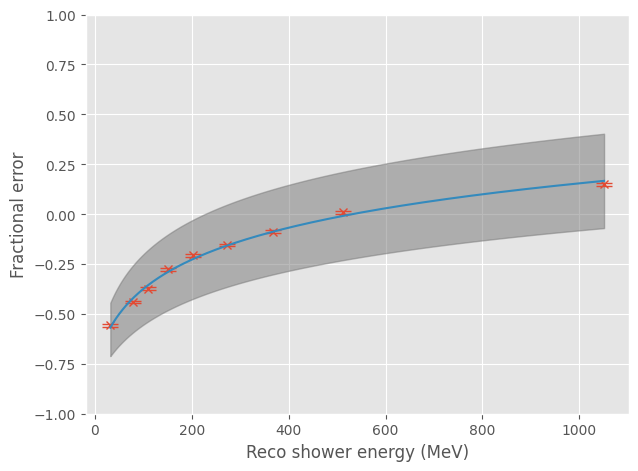

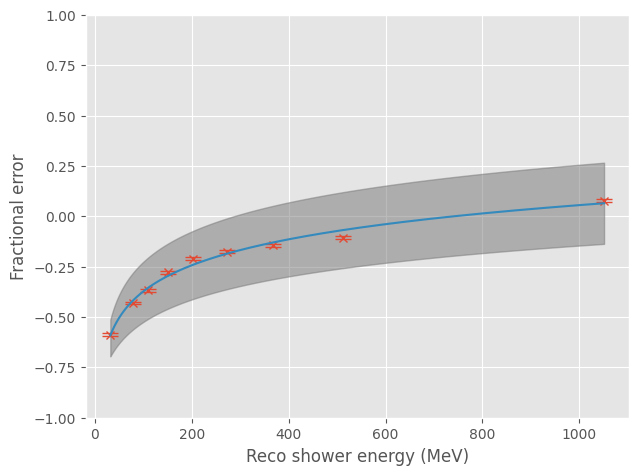

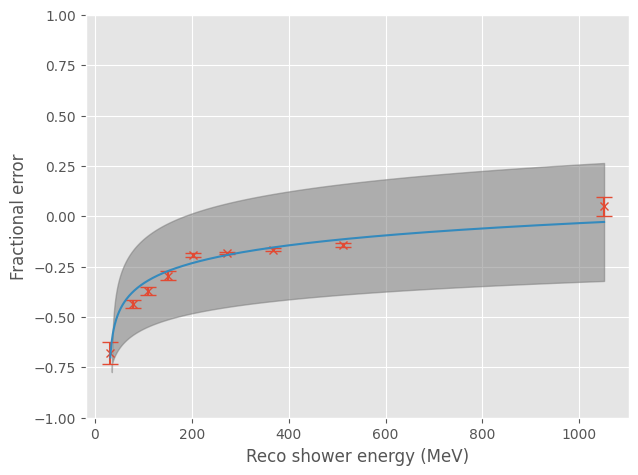

In [11]:
def f(x, a, b, c, d):
    return (a / (b + (c / x))) + d

def h(x, a, b, c, d):
    return a + ((b - a)/(1 + (x/c)**d))

def fe_fit(y_obs, y_err, func):
    x = (bins[1:] + bins[:-1]) / 2
    x_interp = np.linspace(min(x), max(x), 1000)
    popt, pcov = curve_fit(func, x, y_obs, sigma = y_err)
    perr = np.sqrt(np.diag(pcov))

    y_pred = func(x, *popt)
    y_pred_min = func(x, *(popt - perr))
    y_pred_max = func(x, *(popt + perr))
    y_pred_err = (abs(y_pred - y_pred_min) + abs(y_pred - y_pred_max)) / 2

    chisqr = np.sum(((y_obs - y_pred)/y_pred_err)**2)
    ndf = len(y_obs) - len(popt)

    print(f"reduced_chi_squared : {chisqr/ndf}")

    Plots.Plot(x, y_obs, marker = "x", linestyle = "", color = "C0")
    plt.errorbar(x, y_obs, y_err, linestyle = "", capsize = 6, color = "C0")
    Plots.Plot(x_interp, func(x_interp, *popt), newFigure = False, x_scale = "linear", xlabel = "Reco shower energy (MeV)", ylabel = "Fractional error", color = "C1")
    plt.fill_between(x_interp, func(x_interp, *(popt + perr)), func(x_interp, *(popt - perr)), color = "C3", alpha = 0.5)
    plt.ylim(-1, 1)
    return popt

popt_mean = fe_fit(means_simple, sem, ResponseCorrection)
popt_med = fe_fit(median, sem, ResponseCorrection)
popt_fit = fe_fit(cv, cv_err, ResponseCorrection)


In [12]:
def EvaluateFitPerformance(func, fit):
    corrected_energy = df.reco_energy / (func(df.reco_energy, *fit) + 1)
    fec = (corrected_energy / df.true_energy) - 1
    Plots.PlotHist2D(df.fractional_error, fec, x_range = [-1, 1], y_range = [-1, 1])
    Plots.Plot(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), newFigure = False, xlabel = "Fractional error", ylabel = "corrected fractional error")

    Plots.PlotHistComparison([df.fractional_error, fec], labels = ["reco", "corrected"], xRange = [-1, 1], xlabel = "Fractional error", density = False)
    Plots.PlotHistComparison([df.residual, corrected_energy - df.true_energy], labels = ["reco", "corrected"], xRange = [-1000, 1000], xlabel = "residual (MeV)", density = False)
    Hist2DComparison([df.true_energy, df.true_energy], [df.fractional_error, fec], [0, 1200], [-1, 1], bins = 50, cmap = "Accent", x_labels = ["True shower energy (MeV)"]*2, y_labels = ["Fractional error"]*2, titles = ["reco", "corrected"])

    print(f"mean shower energy fractional error: {df.fractional_error.mean()} +- {df.fractional_error.std()}")
    print(f"mean shower energy fractional error after correction: {np.mean(fec)} +- {np.std(fec)}")
    return

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


mean shower energy fractional error: -0.16237320982323436 +- 0.4721893307707888

mean shower energy fractional error after correction: 0.04181733274172506 +- 0.4875160418485937

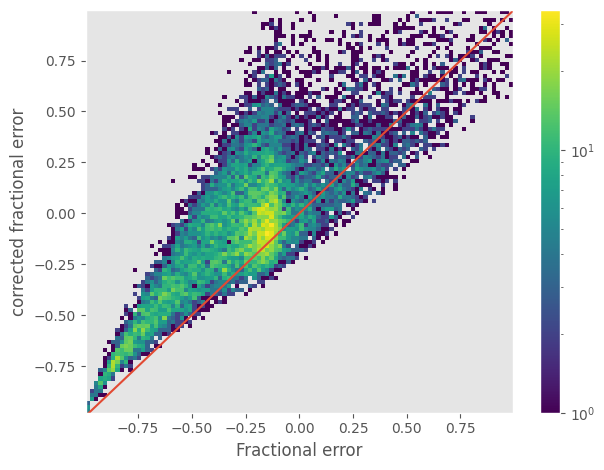

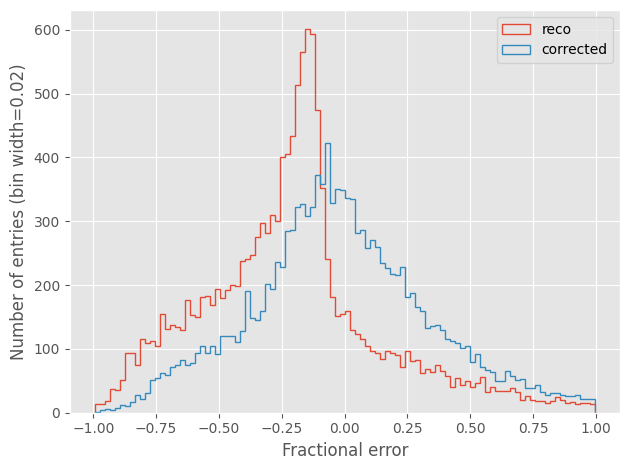

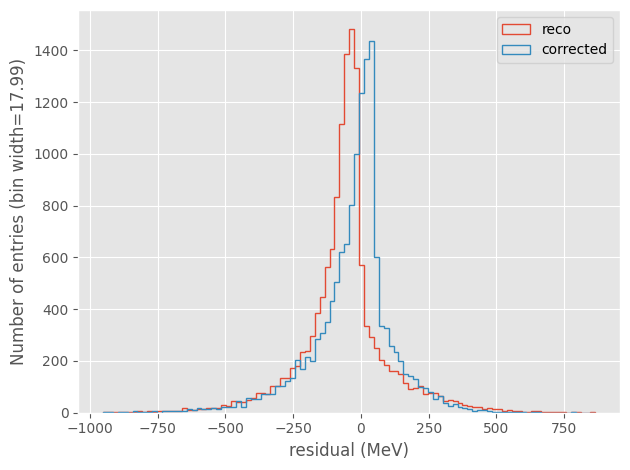

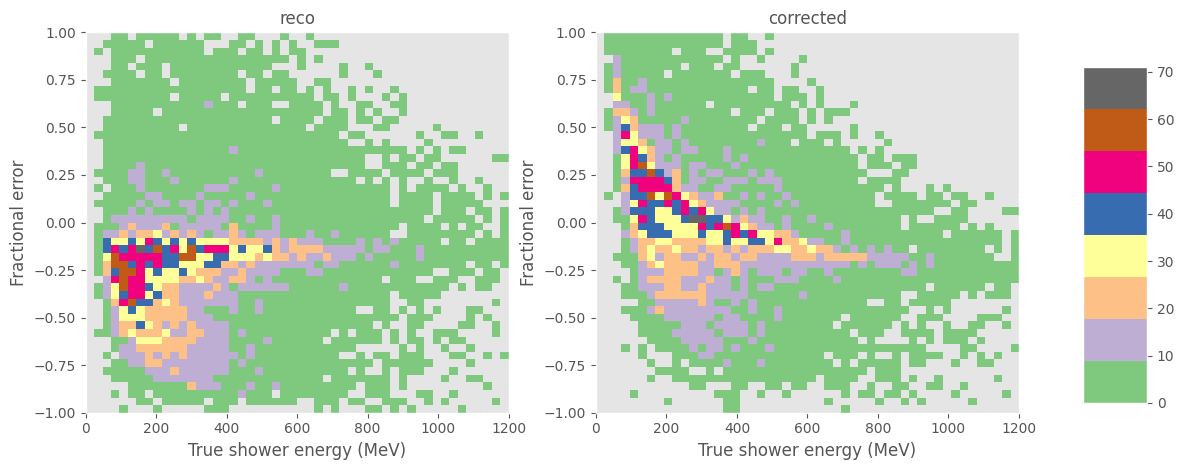

In [13]:
EvaluateFitPerformance(ResponseCorrection, popt_mean)

mean shower energy fractional error: -0.16237320982323436 +- 0.4721893307707888

mean shower energy fractional error after correction: 0.07594605953407821 +- 0.5069700229839912

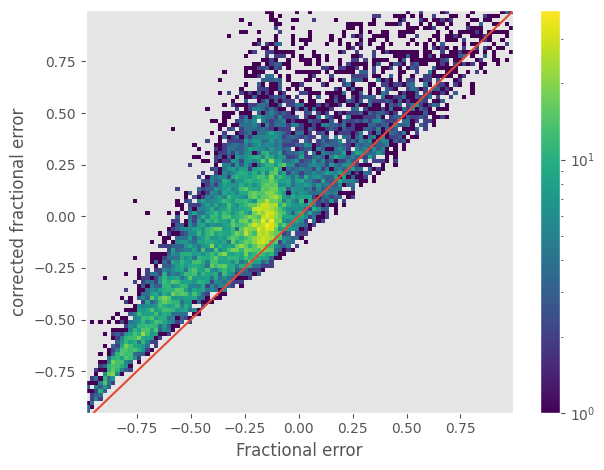

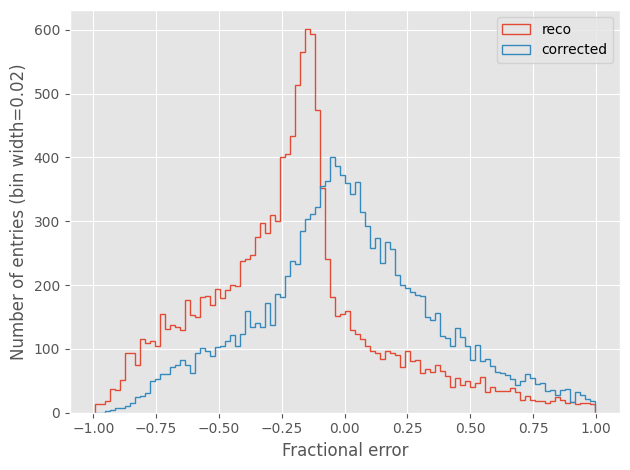

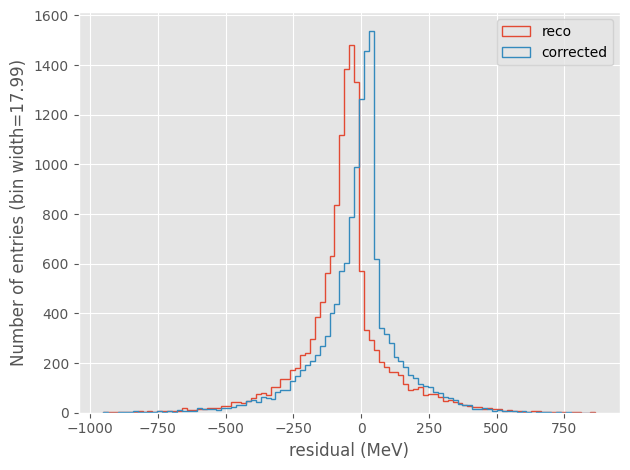

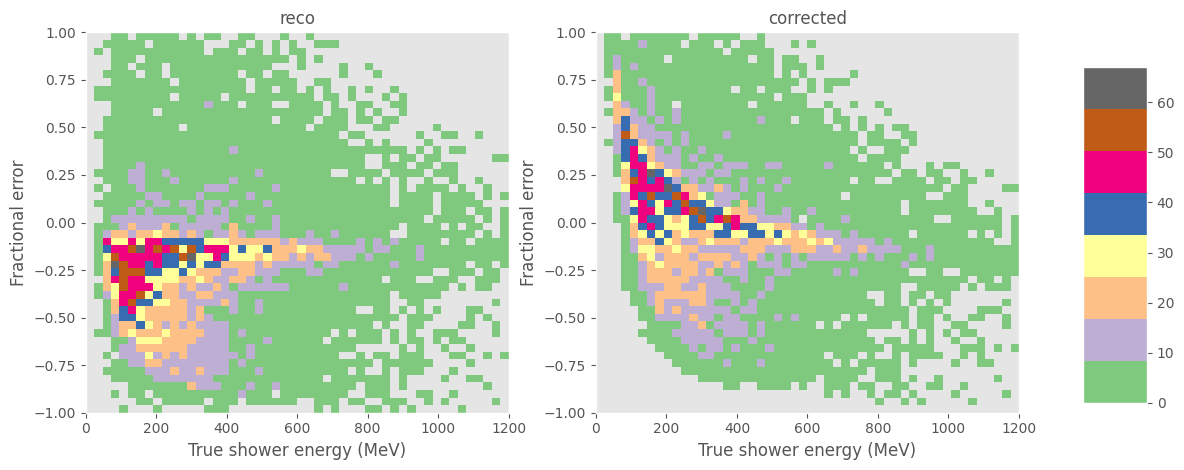

In [14]:
EvaluateFitPerformance(ResponseCorrection, popt_med)

mean shower energy fractional error: -0.16237320982323436 +- 0.4721893307707888

mean shower energy fractional error after correction: 0.07981022460797117 +- 0.6953198391072193

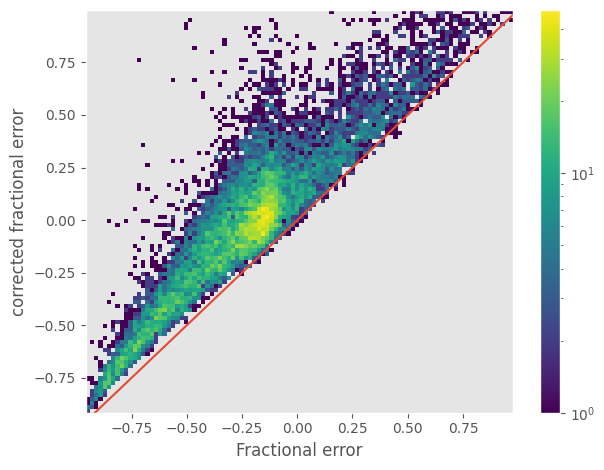

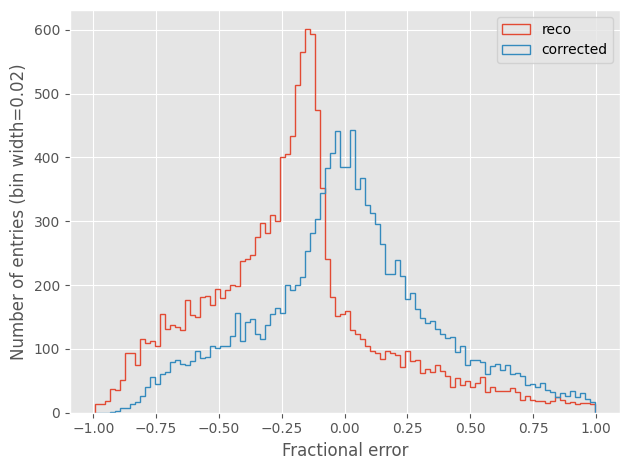

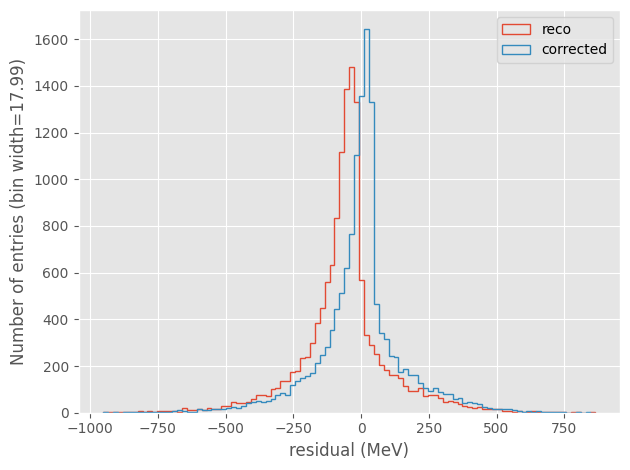

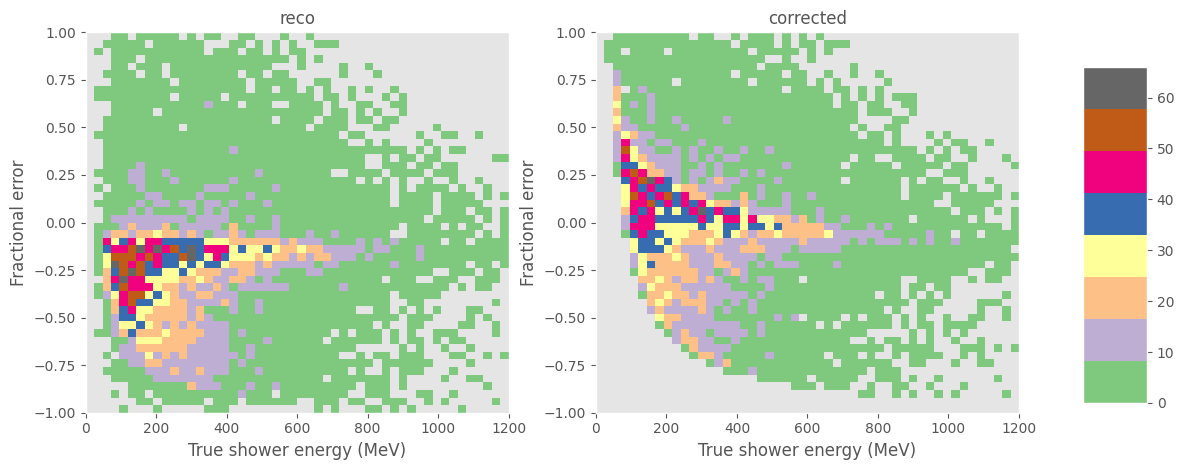

In [15]:
EvaluateFitPerformance(ResponseCorrection, popt_fit)

# Linear vs respone fit

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Uncorrected : -0.16 +- 0.47

Linear : 0.01 +- 0.57

Response : 0.04 +- 0.49

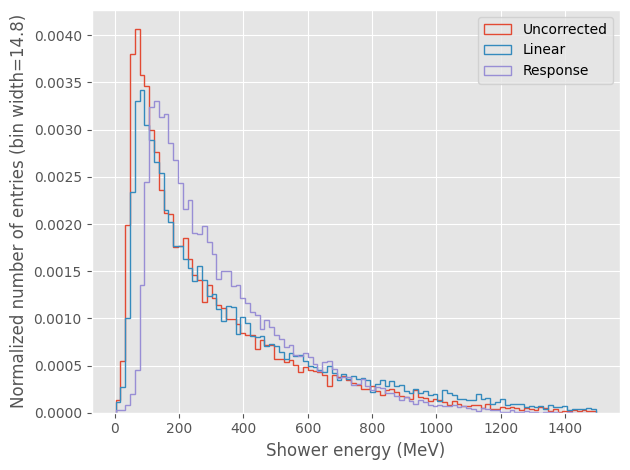

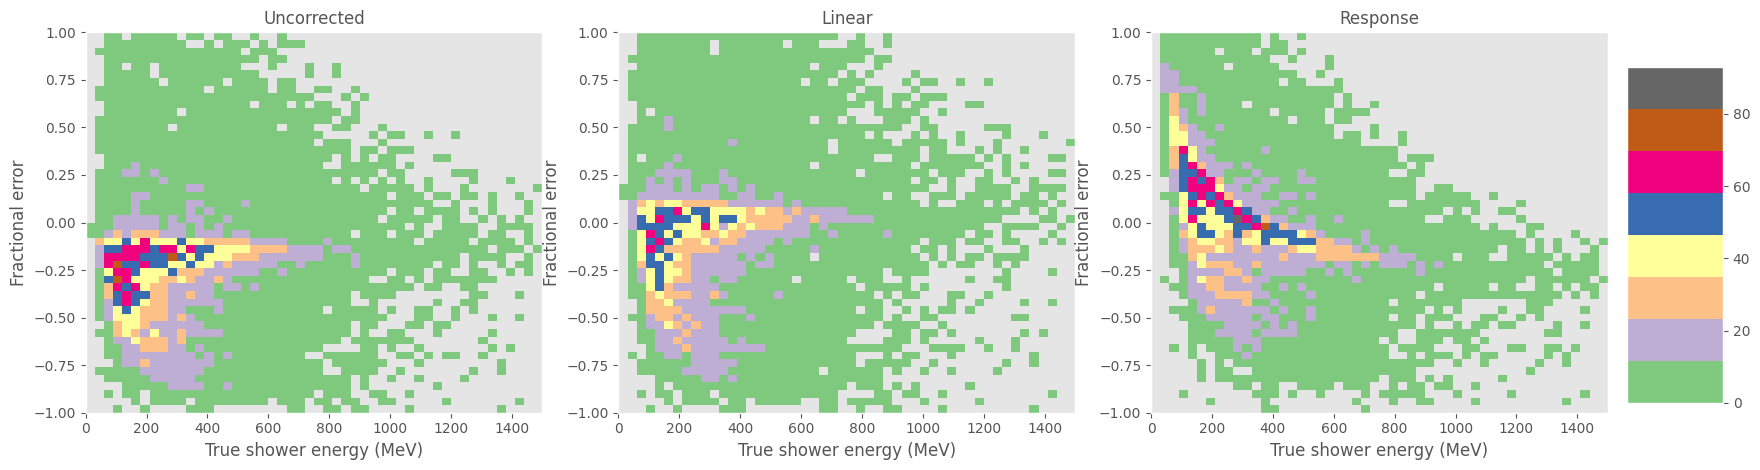

In [104]:
labels = ["Uncorrected", "Linear", "Response"]

linear_corrected_energy = df.reco_energy / linear_correction
reponse_corrected_energy = df.reco_energy / (ResponseCorrection(df.reco_energy, *popt_mean) + 1)

Plots.PlotHistComparison([df.reco_energy, linear_corrected_energy, reponse_corrected_energy], labels = labels, xRange = energy_range, xlabel = "Shower energy (MeV)")

lfe = (linear_corrected_energy / df.true_energy) - 1
rfe = (reponse_corrected_energy / df.true_energy) - 1

Hist2DComparison([df.true_energy, df.true_energy, df.true_energy], [df.fractional_error, lfe, rfe], energy_range, [-1, 1], bins = 50, cmap = "Accent", x_labels = ["True shower energy (MeV)"]*3, y_labels = ["Fractional error"]*3, titles = ["Uncorrected", "Linear", "Response"])

for l, f in zip(labels, [df.fractional_error, lfe, rfe]):
    print(f"{l} : {f.mean():.2f} +- {f.std():.2f}")



In [112]:
import json

params = {}
lp = params["linear_correction_params"] = {"p0" : linear_correction}
rp = params["response_correction_params"] = {f"p{i}" : popt_mean[i] for i in range(len(popt_mean))}

for name, p in params.items():
    with open(name+".json", "w") as f:
        json.dump(p, f)
